In [13]:
# Automatically reload modules before executing code, instead of having to restart kernel
%load_ext autoreload
%autoreload 2

# Setup - Do once (Only in Colab)

In [2]:
try:
    import google.colab
    IN_COLAB = True
    
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir('/content/drive/My Drive/Colab Notebooks/RoboAdvisor/notebooks')
    print('Working directory changed to ' + os.getcwd())  

except:
    IN_COLAB = False




In [3]:
if (IN_COLAB):
    !pip install PyPortfolioOpt==0.5.3
    !pip install pandas==0.22.0
    !pip install zipline==1.3.0
    !pip install matplotlib==3.1.2
    !pip install deap==1.3.1
    !pip install pyfolio
    !pip install cvxopt
    !pip install yahoofinancials


In [4]:
if (IN_COLAB):
    # Some files need to be modified
    !ls /root
    #!cp setup/extension.py ~/.zipline/extension.py
    !cp ../setup/benchmarks.py /usr/local/lib/python3.6/dist-packages/zipline/data/benchmarks.py
    !cp ../setup/loader.py /usr/local/lib/python3.6/dist-packages/zipline/data/loader.py


## Note: After installing modules, please ensure that you restart the runtime!

In [5]:
import pandas as pd
print("PANDAS: " + pd.__version__)
print("If you do not see 0.22.0, please restart the runtime!")

PANDAS: 0.22.0
If you do not see 0.22.0, please restart the runtime!


# Input and Function definitions

In [20]:
#@title Input Variables
_visualise = True #@param ["True", "False"] {type:"raw"}
_bundle_start_date = '2015-01-05' #@param {type:"date"}
_bundle_end_date = '2020-04-03' #@param {type:"date"}
# _end_date = '2019-12-27' #@param {type:"date"}
_capital = 1000000 #@param {type:"slider", min:1000, max:1000000, step:1000}
_benchmark = 'SPY' #@param ["SPY"] {allow-input: true}
_history = 500 #@param {type:"slider", min:100, max:500, step:1}
_calendar = 'NYSE' #@param ["NYSE"] {allow-input: true}

# set algo start date equal to bundle start date
# _start_date = _bundle_start_date
# _end_date = _bundle_end_date

_start_date = '2018-07-21'
_end_date = '2020-04-03'

args = {
    'mode': '1',
    'visualise': _visualise, 
    'start_date': _start_date,
    'end_date': _end_date,
    'bundle_start_date': _bundle_start_date,
    'bundle_end_date': _bundle_end_date,
    'bundle': 'robo-advisor_US',
    'timezone': 'US/Mountain',
    'calendar': _calendar,
    'capital': _capital,
    'benchmark': _benchmark,
    'history': _history
}


## Core imports and Initialisation

In [21]:
import sys
sys.path.append('..')  # add parent folder to sys path

import os
import pickle
from datetime import datetime, timedelta
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm
import pytz
from zipline.data.benchmarks import get_benchmark_returns 
from yahoofinancials import YahooFinancials

from algorithms import run, CRBAlgorithm, OptAlgorithm, TradingSignalAlgorithm
from utils import plot_rolling_returns_from_perf_array, print_table_from_perf_array
import ga

tz = pytz.timezone(args['timezone'])

## Register and ingest bundle

In [22]:
from zipline.data.bundles import register, ingest, unregister, bundles
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.run_algo import load_extensions

start_session = pd.Timestamp(args['bundle_start_date'], tz='utc')
end_session = pd.Timestamp(args['bundle_end_date'], tz='utc')
bundle_name = args['bundle']

load_extensions(default=True, extensions=[], strict=True, environ=os.environ)

# unregister bundle if already exists
if bundle_name in list(bundles):
    unregister(bundle_name)

# register and ingest the bundle
register(
    bundle_name,  # name we select for the bundle
    csvdir_equities(        
        ['daily'], # name of the directory as specified above (named after data frequency)        
        '../data', # path to directory containing the data
    ),
    calendar_name=args['calendar'],  # US Equities
    start_session=start_session,
    end_session=end_session
)


ingest(bundle_name)



 | BND: sid 0
 | BNDX: sid 1
 | DBC: sid 2
 | GLD: sid 3
 | IEF: sid 4
 | SPY: sid 5
 | TLT: sid 6
 | VTI: sid 7
 | VXUS: sid 8
 | XLB: sid 9
 | XLC: sid 10
 | XLE: sid 11
 | XLF: sid 12
 | XLI: sid 13
 | XLK: sid 14
 | XLP: sid 15
 | XLRE: sid 16
 | XLU: sid 17
 | XLV: sid 18
 | XLY: sid 19


Bundle details: RegisteredBundle(calendar_name='NYSE', start_session=Timestamp('2015-01-05 00:00:00+0000', tz='UTC'), end_session=Timestamp('2020-04-03 00:00:00+0000', tz='UTC'), minutes_per_day=390, ingest=<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x0000022E9BD14588>>, create_writers=True)

Asset list: [Equity(0 [BND]), Equity(1 [BNDX]), Equity(2 [DBC]), Equity(3 [GLD]), Equity(4 [IEF]), Equity(5 [SPY]), Equity(6 [TLT]), Equity(7 [VTI]), Equity(8 [VXUS]), Equity(9 [XLB]), Equity(10 [XLC]), Equity(11 [XLE]), Equity(12 [XLF]), Equity(13 [XLI]), Equity(14 [XLK]), Equity(15 [XLP]), Equity(16 [XLRE]), Equity(17 [XLU]), Equity(18 [XLV]), Equity(19 [XLY])]



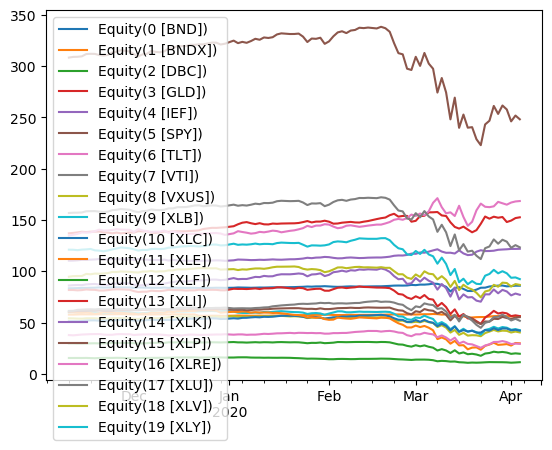

In [23]:
# Verify that bundle has been registered 
from zipline.data import bundles
bundle = bundles.load(bundle_name)
assets = bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)
symbols = [a.symbol for a in assets]

print('Bundle details:', bundles.bundles[bundle_name])
print('\nAsset list:', bundle.asset_finder.retrieve_all(bundle.asset_finder.sids))
print()

# See sample of data
from zipline.data.data_portal import DataPortal
from zipline.utils.calendars import get_calendar
my_data = DataPortal(bundle.asset_finder, get_calendar(args['calendar']),
                       bundle.equity_daily_bar_reader.first_trading_day,
                       equity_minute_reader=bundle.equity_minute_bar_reader,
                       equity_daily_reader=bundle.equity_daily_bar_reader,
                       adjustment_reader=bundle.adjustment_reader)

my_data_pricing = my_data.get_history_window(assets, end_session, 100, '1d', 'close', 'daily')
my_data_pricing.plot()


# Run Algorithms

In [24]:
# initialise variables
from zipline.api import *
from zipline.api import symbols
from zipline.utils.calendars import get_calendar
from zipline import run_algorithm

bundle_name = args['bundle'] # bundle = 'alpaca'

raw_start = tz.localize(datetime.strptime(args['start_date'], '%Y-%m-%d'))

# calculate actual start date, 
# taking into account required HISTORY of trading days for given trading calendar
tc = get_calendar(args['calendar'])
# start = tc.sessions_window(start_session, args['history'])[-1] # start = raw_start + trading_days(HISTORY)
start = raw_start

end = tz.localize(datetime.strptime(args['end_date'], '%Y-%m-%d'))
capital_base = args['capital'] # 100000.00 

print(f'Algorithm will start with capital of ${capital_base:,d}.')
print('Backtest from %s to %s' % (start, end))
print('History will be collected for %d trading-days from %s' % (args['history'], raw_start))

Algorithm will start with capital of $1,000,000.
Backtest from 2018-07-21 00:00:00-06:00 to 2020-04-03 00:00:00-06:00
History will be collected for 500 trading-days from 2018-07-21 00:00:00-06:00


## Portfolios based on asset classes

### Algorithm 1 - pre-assembled fixed basket of ETFs with constant-mix rebalancing 

1A - Vanguard Core Series with risk-baskets

In [46]:
a_vanguard = CRBAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES")

enabled = False

if (enabled):
    # run algorithm for a range of risk levels
    perfData = []
    step = 5
    for r in tqdm(range(0, 10, step)):
        a_vanguard.risk_level = r
        perfData.append(run("RISK%i" % r, a_vanguard, bundle_name, start, end, capital_base, analyze=False))
                
#         perfData.append(("RISK%i" % r, run_algorithm(start=start, end=end,
#                         initialize=a_vanguard.initialize, handle_data=a_vanguard.handle_data,                            
#                         capital_base=capital_base, environ=os.environ, bundle=bundle_name
#                         # analyze=analyze,
#         )))

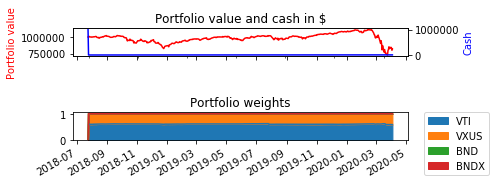

d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,
d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [15]:
# Compare daily vs monthly rebalancing
a_vanguard.risk_level = 10
a_vanguard.rebalance_freq = 'daily'
test = []
test.append(run("rebal daily", a_vanguard, bundle_name, start, end, capital_base, analyze=True))

a_vanguard.rebalance_freq = 'monthly'
test.append(run("rebal monthly", a_vanguard, bundle_name, start, end, capital_base, analyze=False))

from utils import print_table_from_perf_array
print_table_from_perf_array(test, None)

1B - Ray Dalio's simplified "All Weather" Portfolio that is designed to weather through any financial climate.
It advocates the following distribution:
* 30% stocks (eg VTI)
* 40% long-term bonds (eg TLT)
* 15% intermediate-term bonds (eg IEF)
* 7.5% gold (eg GLD)
* 7.5% commodities (eg DBC)

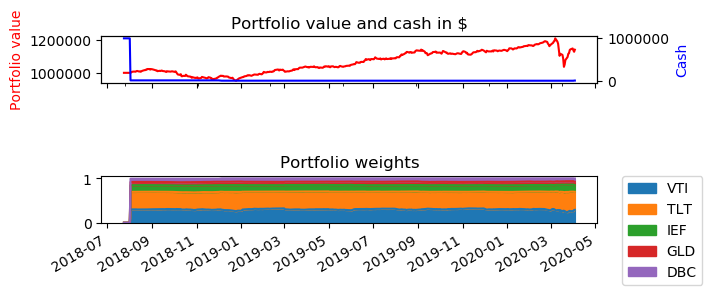

In [47]:
a_dalio = CRBAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER")

if ('perfData' not in locals()): perfData = []
perfData.append(run("All Weather", a_dalio, bundle_name, start, end, capital_base))

### Algorithm 2 - pre-assembled fixed basket of ETFs with Modern Portfolio Theory for rebalancing

MPT (max sharpe)


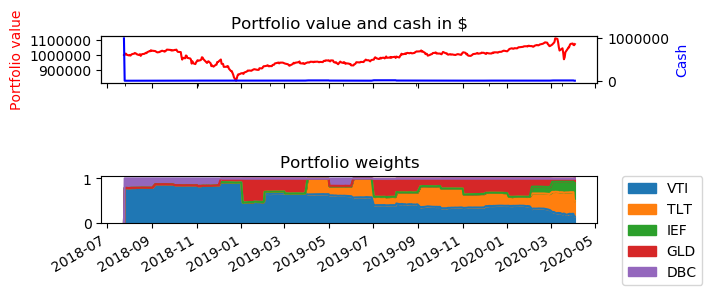

MPT (min volatility)


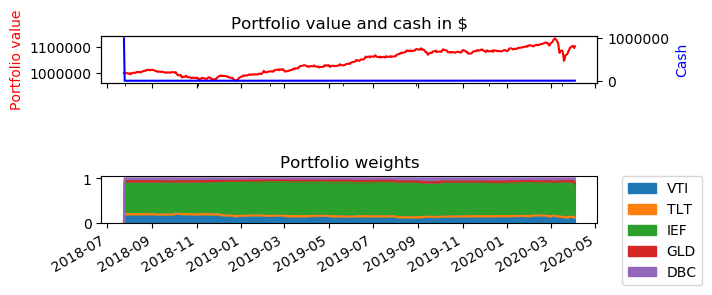

In [48]:
COLLECT_BEFORE_TRADING = False
if ('perfData' not in locals()): perfData = []

# # MPT for max-sharpe
# a_mpt1 = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
#                       collect_before_trading=COLLECT_BEFORE_TRADING,
#                       history=args['history'], objective='max_sharpe')

# # MPT for min-volatility
# a_mpt2 = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
#                       collect_before_trading=COLLECT_BEFORE_TRADING,
#                       history=args['history'], objective='min_volatility')

a_mpt1 = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='max_sharpe')

# MPT for min-volatility
a_mpt2 = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='min_volatility')


print('MPT (max sharpe)')
perfData.append(run("MPT (max sharpe)", a_mpt1, bundle_name, start, end, capital_base))

print('MPT (min volatility)')
perfData.append(run("MPT (min volatility)", a_mpt2, bundle_name, start, end, capital_base))

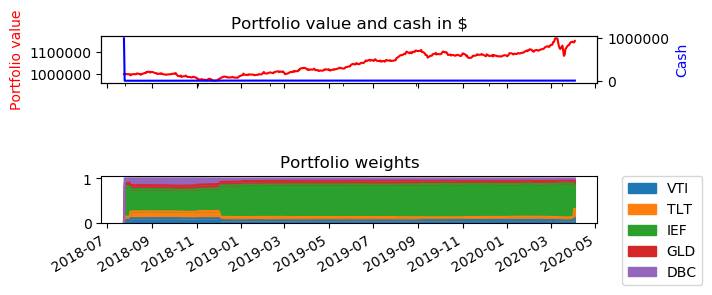

In [28]:
COLLECT_BEFORE_TRADING = False
if ('perfData' not in locals()): perfData = []

# Hierarchical risk parity portfolio
# a_hrp = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
#                       collect_before_trading=COLLECT_BEFORE_TRADING,
#                       history=args['history'], objective='hrp')
a_hrp = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='hrp')

perfData.append(run("HRP", a_hrp, bundle_name, start, end, capital_base))

### Results Comparison

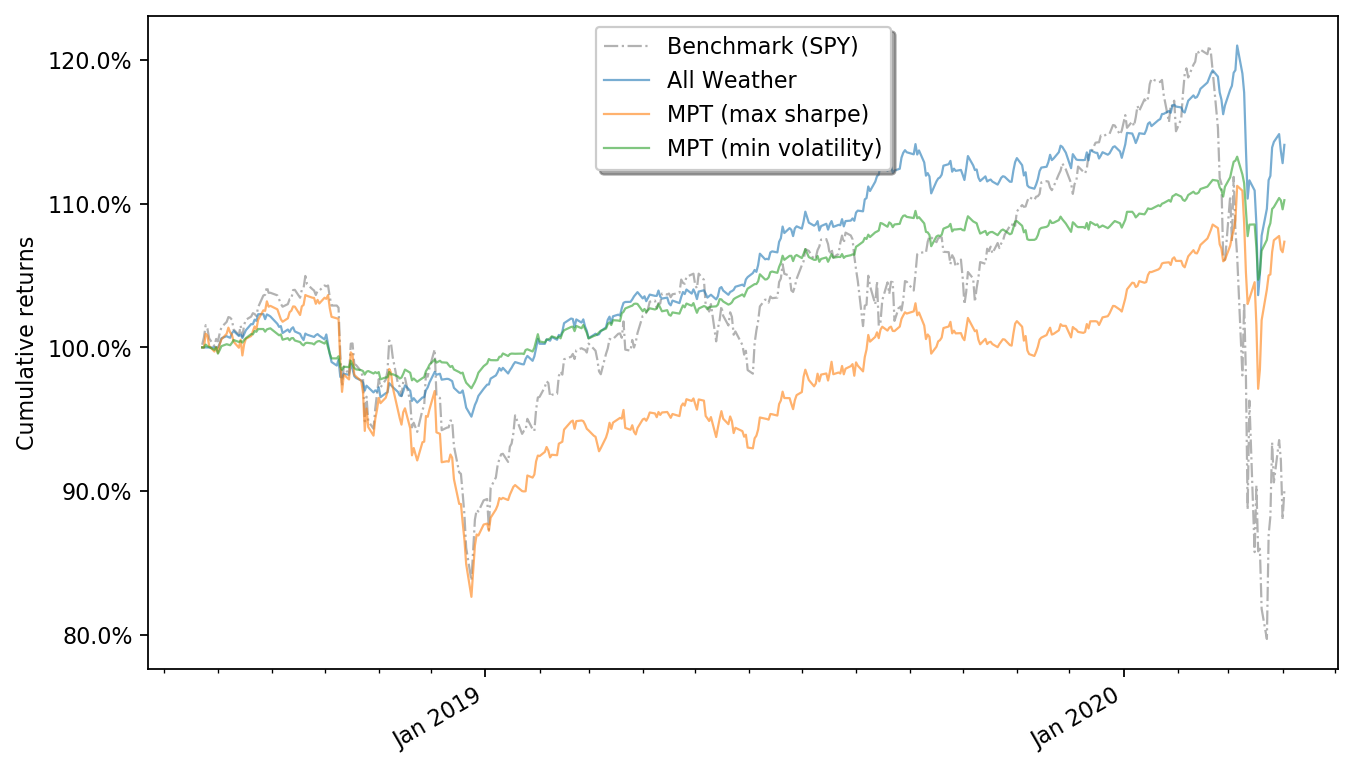

In [50]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=160, facecolor='w', edgecolor='k')

# Get benchmark returns and compare it with our algorithm's returns
bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']

ax = plot_rolling_returns_from_perf_array(perfData, bm_returns)
_ = print_table_from_perf_array(perfData, bm_returns, True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=1)

## Portfolios based on sectors
with universe of 11 SPDR sector ETFs

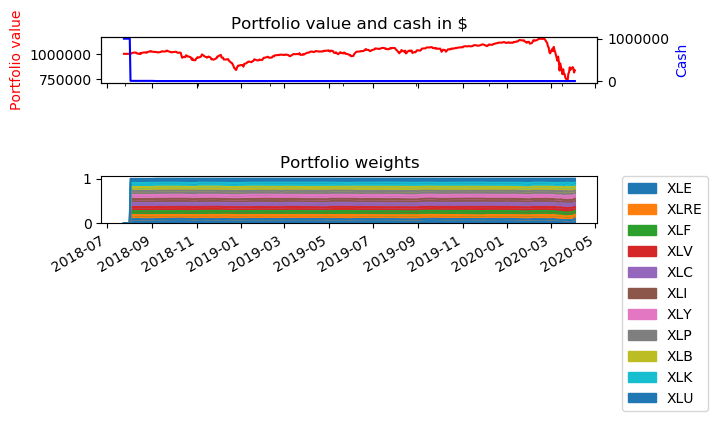

In [51]:
a_spy1 = CRBAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS")

if ('perfSPDR' not in locals()): perfSPDR = []
perfSPDR.append(run("Constant-Rebalancing (Equal weights)", a_spy1, bundle_name, start, end, capital_base))

MPT (max sharpe)


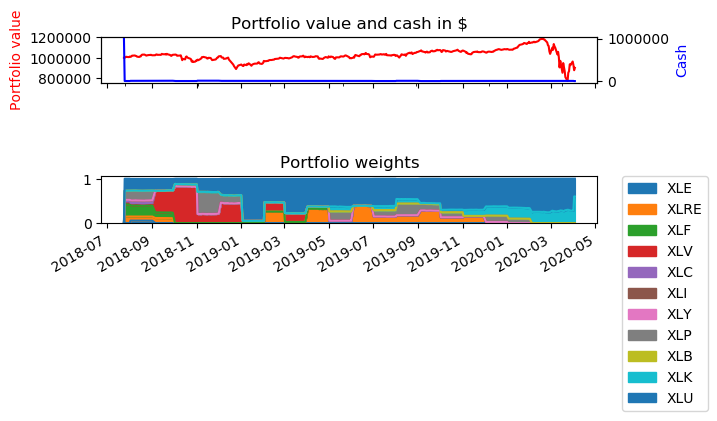

MPT (min volatility)


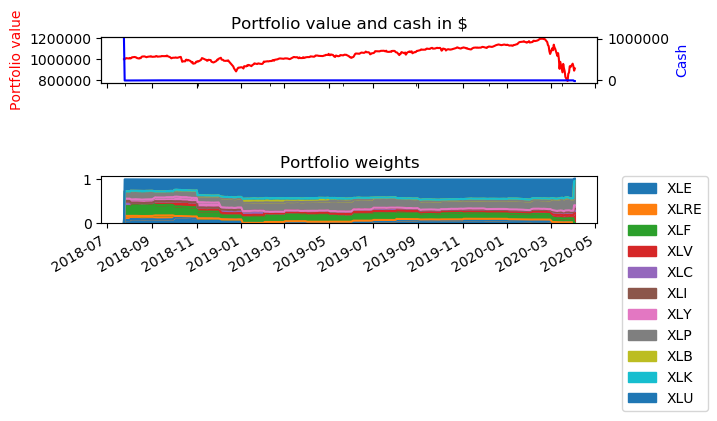

HRP


In [52]:
a_spy2_ms = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='max_sharpe')
a_spy2_mv = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='min_volatility')
a_sp2_hrp = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='hrp')

if ('perfSPDR' not in locals()): perfSPDR = []
print("MPT (max sharpe)")
perfSPDR.append(run("MPT (max sharpe)", a_spy2_ms, bundle_name, start, end, capital_base))

print("MPT (min volatility)")
perfSPDR.append(run("MPT (min volatility)", a_spy2_mv, bundle_name, start, end, capital_base))

print("HRP")
perfSPDR.append(run("HRP", a_sp2_hrp, bundle_name, start, end, capital_base))

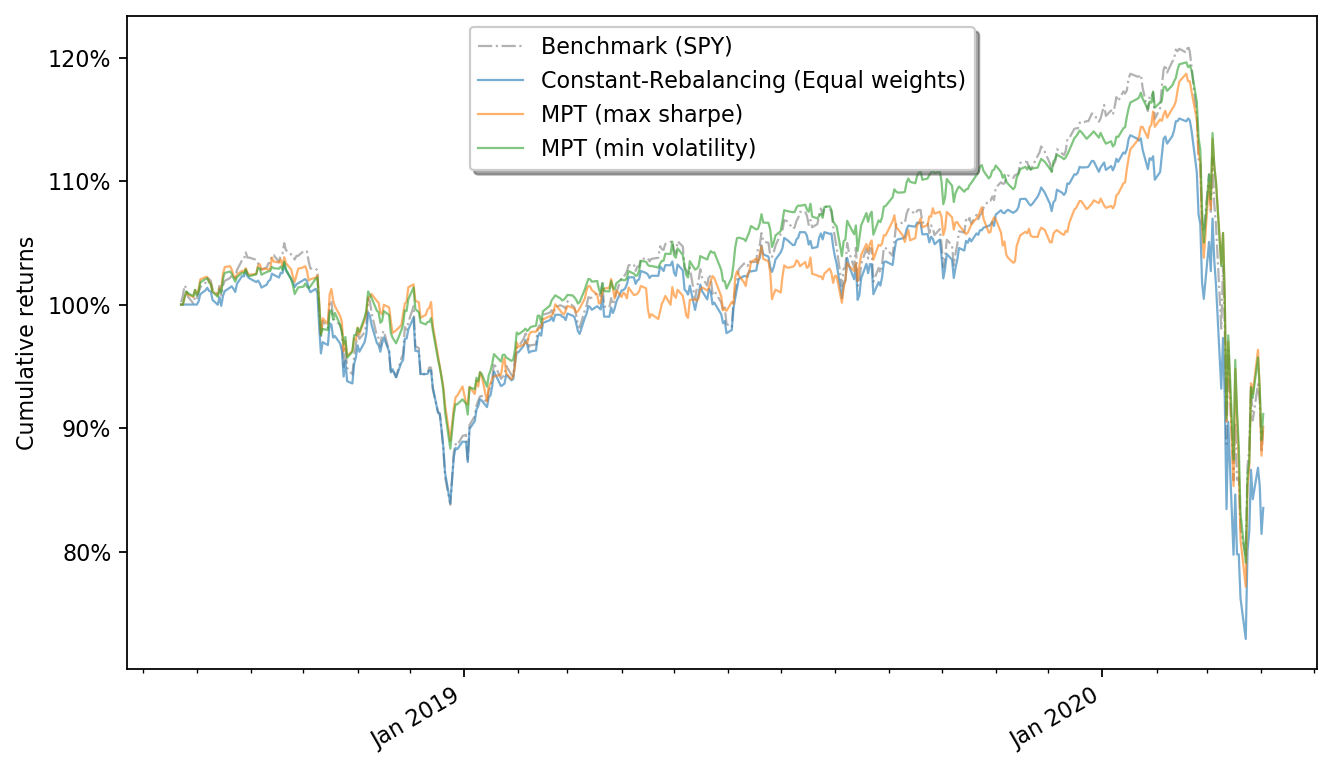

In [54]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=160, facecolor='w', edgecolor='k')

# Get benchmark returns and compare it with our algorithm's returns
bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']

ax = plot_rolling_returns_from_perf_array(perfSPDR, bm_returns)
_ = print_table_from_perf_array(perfSPDR, bm_returns, True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=1)

### Conclusion: It seems that sector-based portfolio does not benefit much from portfolio optimisation

---

## Use Sentiments as trading signals to optimise portfolio based on asset-classes

### Get preprocessed sentiments from file, and create benchmarks for comparison

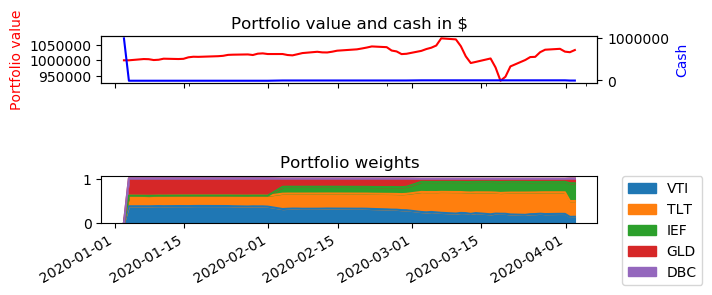

In [59]:
trade_freq = 'weekly'
history = 7

filepath='../data/twitter/sentiments_overall_daily.csv'
social_media = pd.read_csv(filepath, usecols=['date', 'buzz', 'finBERT', 'sent12', 'sent26'])
social_media['date'] = pd.to_datetime(social_media['date'], format="%Y-%m-%d", utc=True)
social_media.set_index('date', inplace=True, drop=True)

social_media[['sent12', 'sent26']].plot()

# We will train based on data prior to 2020-01-01, and test on data after that.
# This will test whether the optimised parameters are robust and able to perform in the covid-19 market crash
train_start = tz.localize(datetime.strptime(args['start_date'], '%Y-%m-%d'))
train_end = tz.localize(datetime.strptime('2020-01-01', '%Y-%m-%d'))
test_start = tz.localize(datetime.strptime('2020-01-02', '%Y-%m-%d'))
test_end = tz.localize(datetime.strptime(args['end_date'], '%Y-%m-%d'))

# Create benchmark returns for comparison
bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']
bm_test = get_benchmark_returns(args['benchmark'], test_start, test_end)  # requires network connection
bm_test.name = 'Benchmark (%s)' % args['benchmark']

# All-weather baselines
a_dalio = CRBAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER")
bm_all_weather = run("All Weather", a_dalio, bundle_name, start, end, capital_base, analyze=False)
bm_aw_test = run("All Weather", a_dalio, bundle_name, test_start, test_end, capital_base, analyze=False)

# MPT baselines
a_mpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=False, history=args['history'], objective='max_sharpe')
bm_mpt = run("MPT (Max Sharpe)", a_mpt, bundle_name, start, end, capital_base, analyze=False)
bm_mpt_test = run("MPT (Max Sharpe)", a_mpt, bundle_name, test_start, test_end, capital_base, analyze=True)

Buy the index SPY, but use trading signals from the prediction model

Baseline: Buy-and-hold SPY

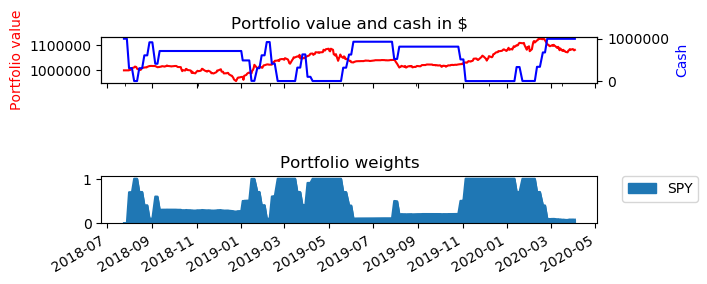

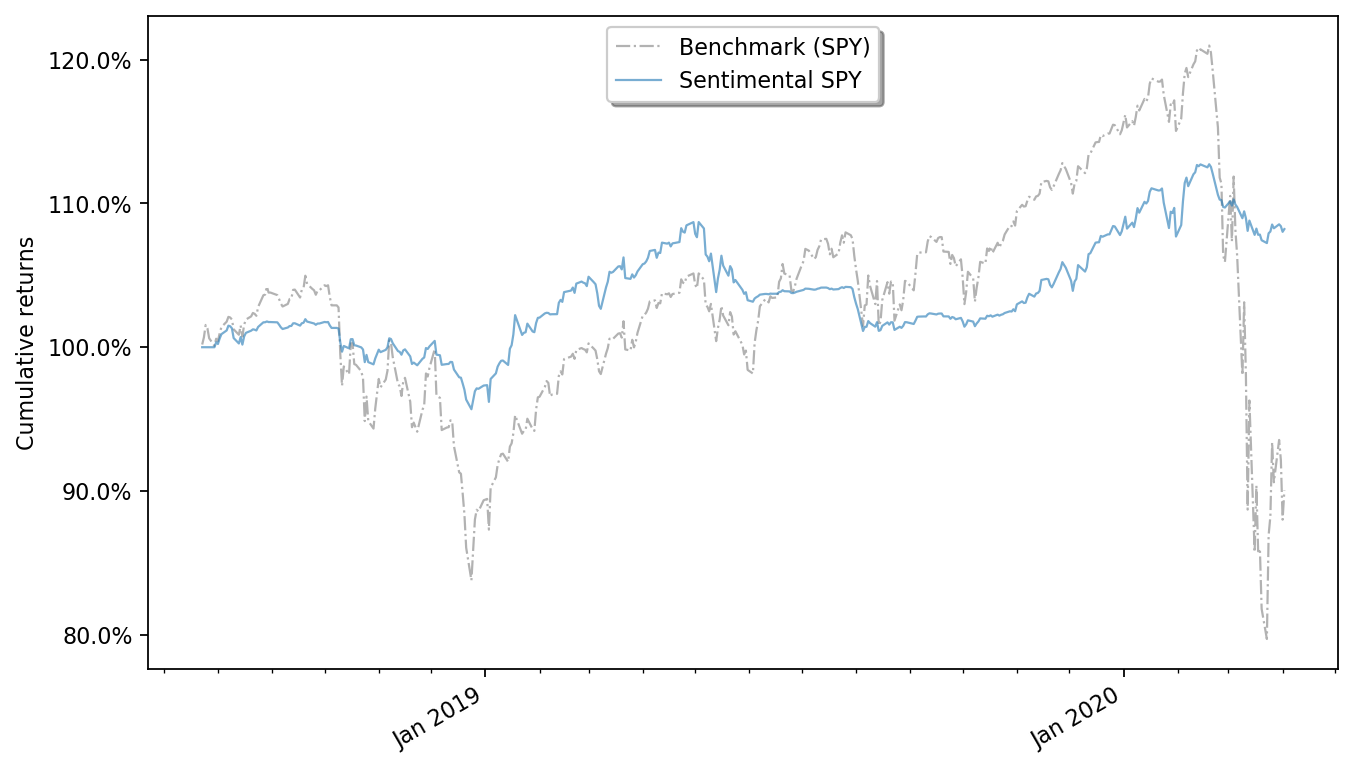

In [60]:
def trading_fn(stockname, date, lookback):    
    df = social_media
    yesterday_date = date - pd.Timedelta(days=1)
    yesterday_social_media = df.iloc[df.index.get_loc(yesterday_date, method='nearest')]
    
    # if sent12 > sent26 -> buy
    # if sent12 < sent26 -> sell    
    buzz = yesterday_social_media['buzz']
    sentiment = yesterday_social_media['sent12'] - yesterday_social_media['sent26']
    
    signal = 0
    if sentiment > 0: signal = 0.5
    elif sentiment < 0: signal = -0.3
    return signal
    
a_index = TradingSignalAlgorithm(verbose=False, stocks=['SPY'], rebalance_freq=trade_freq, trading_signal=trading_fn)

perfTS = []
if ('perfTS' not in locals()): perfTS = []
a_index_results = run("Sentimental SPY", a_index, bundle_name, start, end, capital_base)
perfTS.append(a_index_results)


from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=160, facecolor='w', edgecolor='k')

ax = plot_rolling_returns_from_perf_array([a_index_results], bm_returns)
_ = print_table_from_perf_array(perfTS, bm_returns, True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=1)

It seems like it is able to minimise losses during rapid selling, but we end up holding a lot of uninvested cash during market crashes

---

### Use All-Weather portfolio, but use trading signals to adjust allocation (eg shift to bonds/gold when market is bad)

Let's call this "Sentimental All-Weather" (SAW)

Baseline: All-Weather

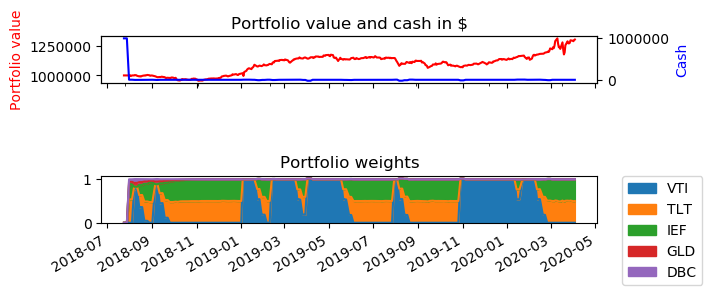

,Baseline,All Weather,SAW
Annual return,-6.776%,8.07%,16.868%
Cumulative returns,-11.259%,14.089%,30.309%
Annual volatility,25.207%,8.64%,12.672%
Sharpe ratio,-0.151275,0.941828,1.29361
Calmar ratio,-0.198688,0.562316,1.62815
Stability,0.228746,0.835564,0.632436
Max drawdown,-34.105%,-14.351%,-10.36%
Omega ratio,0.966166,1.20527,1.301
Sortino ratio,-0.199684,1.22809,1.9082
Skew,-0.764533,-2.09681,0.084318


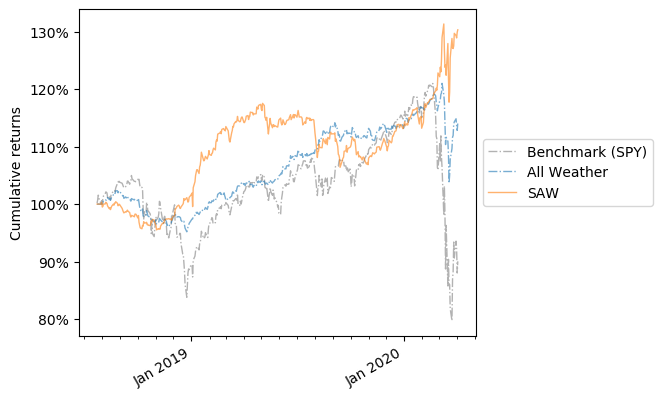

In [61]:
# 'VTI' - stock, 'TLT' - long-term bond, 'IEF'- medium-term bond, 'GLD'- commodity, 'DBC'- commodities
def saw_trading_fn(stock, date, lookback):
    stockname = stock.symbol
    df = social_media
    yesterday_date = date - pd.Timedelta(days=1)
    yesterday_social_media = df.iloc[df.index.get_loc(yesterday_date, method='nearest')]
    
    # if sent12 > sent26 -> bullish --> buy stocks, sell bonds
    # if sent12 < sent26 -> sell --> sell stocks, buy bonds
    buzz = yesterday_social_media['buzz']
    sentiment = yesterday_social_media['sent12'] - yesterday_social_media['sent26']
    
    # just try some parameters
    signal = 0
    if stockname not in ['GLD', 'DBC']:
        if sentiment > 0: signal = 0.5 if stockname in ['VTI'] else -0.5
        elif sentiment < 0: signal = -0.3 if stockname in ['VTI'] else 0.3
                
    return signal
    


a_saw = TradingSignalAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                                       rebalance_freq=trade_freq, trading_signal=saw_trading_fn, 
                                      initial_weights=[0.3,0.4,0.15,0.075,0.075], normalise_weights=True)

# if ('perfTS' not in locals()): perfTS = []
a_saw_results = run("SAW", a_saw, bundle_name, start, end, capital_base)
# perfTS.append(a_all_weather_results)

plot_rolling_returns_from_perf_array([bm_all_weather, a_saw_results], bm_returns, extra_bm=1)
print_table_from_perf_array([bm_all_weather, a_saw_results], bm_returns, True)

Since this looks promising (Annual returns of 16.9%, and max draw-down of only 10% despite the covid-19 market crash), let's see if we can optimise the parameters

Let's use Genetic Algorithm (GA) to optimise parameters

In [62]:
# %matplotlib notebook
# import sys
# sys.path.append('..')  # add parent folder to sys path
# import ga
# ga.example(npop=5, ngen=10, filepath="../data/twitter/sentiments_overall_daily.csv")
# print()

In [63]:
%matplotlib notebook

stocks = ['VTI', 'TLT', 'IEF', 'GLD', 'DBC']  # list of stocks used by All-Weather
NPOP = 1000
NGEN = 20
seed = 300
opt_type = "saw"
objective = "max_ret"  # max_sharpe, max_ret, min_vol
toSolve = False

# ---------------------------------------------------

pickle_name = f"./output/{opt_type.upper()}_GA_{objective.upper()}"

kpi_map = {
    "max_ret": "algorithm_period_return",
    "max_sharpe": "sharpe",
    "min_vol": "algo_volatility"
}

kwargs = {"social_media": social_media, "bundle_name": bundle_name, 
          "train_start": train_start, "train_end": train_end, "capital_base": capital_base, 
          "trade_freq": trade_freq, "kpi": kpi_map.get(objective, "sharpe")}

if toSolve:
    if (objective != "min_vol"):
        top10, log, hof = ga.run_saw_ga("FitnessMax", NPOP, NGEN, pickle_name, 
                                    eval_fn=ga.eval_final_perf, stocks=stocks, seed=seed, **kwargs)
    else:
        top10, log, hof = ga.run_saw_ga("FitnessMin", NPOP, NGEN, pickle_name, 
                                    eval_fn=ga.eval_min_vol, stocks=stocks, seed=seed, **kwargs)
        
else:
    with open(f"{pickle_name}.pickle", "rb+") as f:
        top10 = pickle.load(f)    

best = top10[0]
w = OrderedDict()
i = 0

for s in stocks:
    w[s] = {"p": best[i], "n": best[i+1]}
    i = i + 2

GA-optmised SAW for max_ret


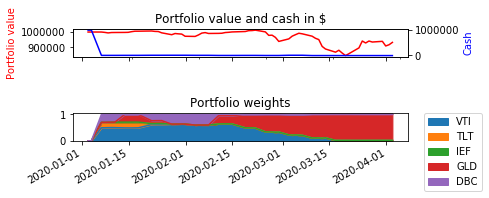

,Baseline,All Weather,SAW-GA (max_ret)
Annual return,-65.358%,-8.531%,-23.897%
Cumulative returns,-23.603%,-2.239%,-6.7%
Annual volatility,55.046%,17.77%,23.784%
Sharpe ratio,-1.64796,-0.413277,-1.03062
Calmar ratio,-1.91638,-0.594397,-1.47061
Stability,0.684932,0.23885,0.534859
Max drawdown,-34.105%,-14.353%,-16.25%
Omega ratio,0.725629,0.912,0.822613
Sortino ratio,-2.13837,-0.506726,-1.41544
Skew,-0.190885,-1.44299,0.287969


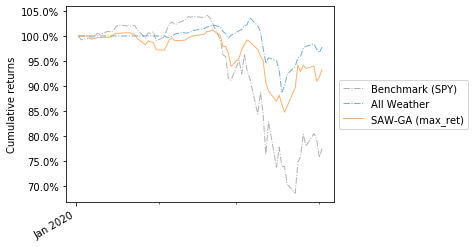

In [64]:
# Test on out-of-sample data
%matplotlib inline

algo_saw = TradingSignalAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                                   rebalance_freq=trade_freq, trading_signal=ga.saw_ga_trading_fn, 
                                  initial_weights=[0.3,0.4,0.15,0.075,0.075], normalise_weights=True, 
                                      **{"weights": w, "social_media": social_media})

print(f"GA-optmised SAW for {objective}")
saw_ga_test = run(f"SAW-GA ({objective})", algo_saw, bundle_name, test_start, test_end, capital_base, analyze=True)

ax = plot_rolling_returns_from_perf_array([bm_aw_test, saw_ga_test], bm_test, extra_bm=1)
print_table_from_perf_array([bm_aw_test, saw_ga_test], bm_test, True)

GA-optmised SAW for max_ret


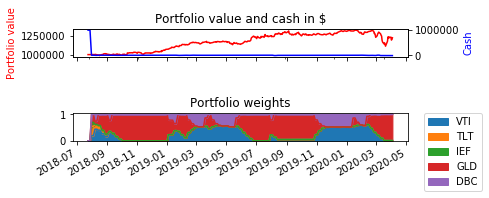

,Baseline,All Weather,SAW-GA (max_ret)
Annual return,-6.776%,8.07%,12.737%
Cumulative returns,-11.259%,14.089%,22.583%
Annual volatility,25.207%,8.64%,12.889%
Sharpe ratio,-0.151275,0.941828,0.994602
Calmar ratio,-0.198688,0.562316,0.786528
Stability,0.228746,0.835564,0.835704
Max drawdown,-34.105%,-14.351%,-16.194%
Omega ratio,0.966166,1.20527,1.20486
Sortino ratio,-0.199684,1.22809,1.45125
Skew,-0.764533,-2.09681,0.0863942


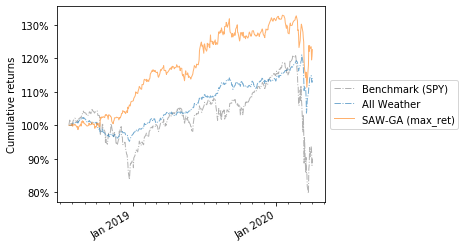

In [65]:
# Test on entire period
print(f"GA-optmised SAW for {objective}")
saw_ga_all = run(f"SAW-GA ({objective})", algo_saw, bundle_name, train_start, test_end, capital_base, analyze=True)

plot_rolling_returns_from_perf_array([bm_all_weather, saw_ga_all], bm_returns, extra_bm=1)
print_table_from_perf_array([bm_all_weather, saw_ga_all], bm_returns, True)

---

We can repeat the above for different objectives (eg maximise returns, minimise volatility, etc) and for various population size, generations, and random seed... 

After running for multiple times, let's compare all the results

In [66]:
from ga import compareResults

# opt_type = "saw"
# objective = "max_sharpe"  # max_sharpe, max_ret, min_vol
# base_name = f"{opt_type.upper()}_GA_{objective.upper()}"

kwargs = {"social_media": social_media, "bundle_name": bundle_name, 
          "train_start": train_start, "train_end": train_end, 
          "test_start": test_start, "test_end": test_end, 
          "capital_base": capital_base, 
          "stocks": stocks, "trade_freq": trade_freq}

test_ga_mr, all_ga_mr = compareResults(base_name="./output/SAW_GA_MAX_RET", opt_type=opt_type, prefix="MR", **kwargs)
test_ga_ms, all_ga_ms = compareResults(base_name="./output/SAW_GA_MAX_SHARPE", opt_type=opt_type, prefix="MS", **kwargs)
test_ga_mv, all_ga_mv = compareResults(base_name="./output/SAW_GA_MIN_VOL", opt_type=opt_type, prefix="MV", **kwargs)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


In [67]:
test_ga = test_ga_mr + test_ga_ms + test_ga_mv
all_ga = all_ga_mr + all_ga_ms + all_ga_mv

Test on out-of-sample data


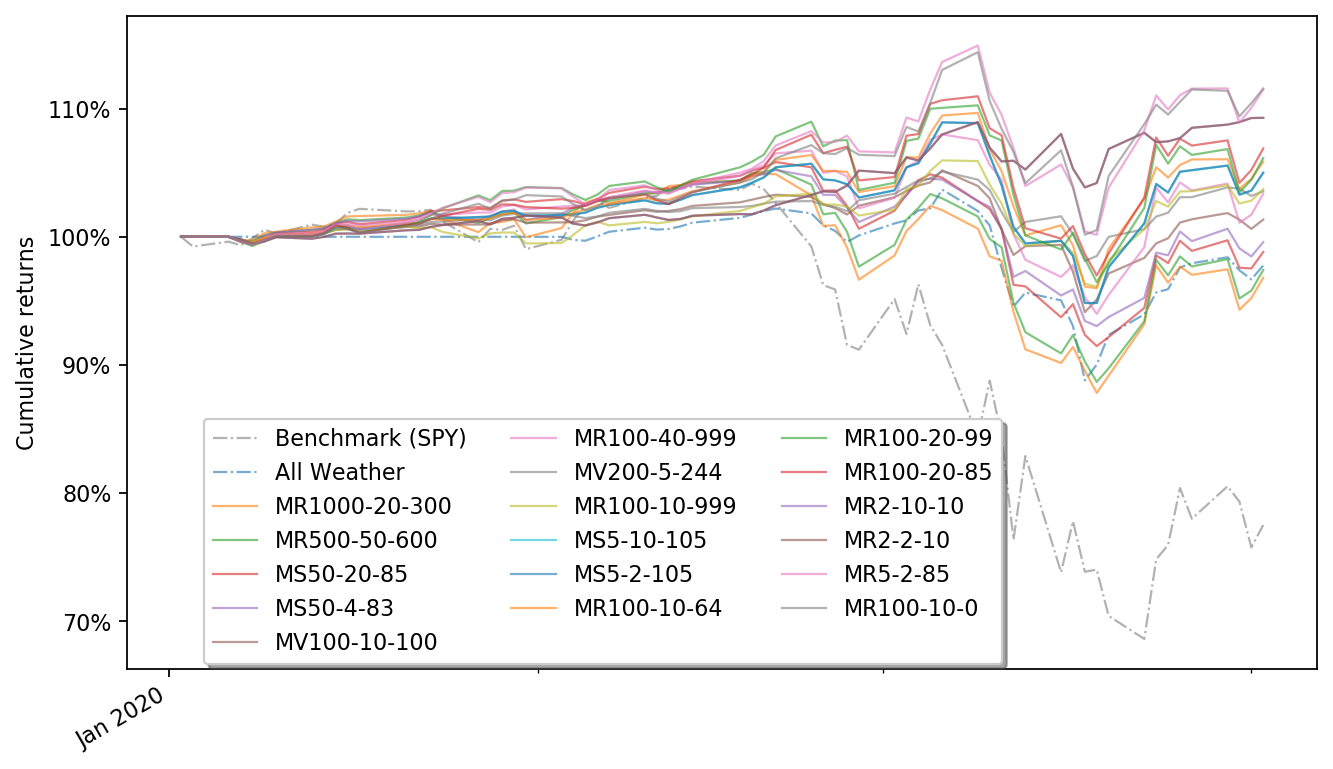

In [76]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=160, facecolor='w', edgecolor='k')


# sort by performance (cumulative returns)
all_ga.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=False)
test_ga.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=False)

all = [bm_all_weather] + all_ga
test = [bm_aw_test] + test_ga

print('Test on out-of-sample data')
ax = plot_rolling_returns_from_perf_array(test, bm_test, extra_bm=1)
_ = print_table_from_perf_array(test, bm_test, True)

ax.legend(loc='upper center', bbox_to_anchor=(0.4, 0.4), shadow=True, ncol=3)

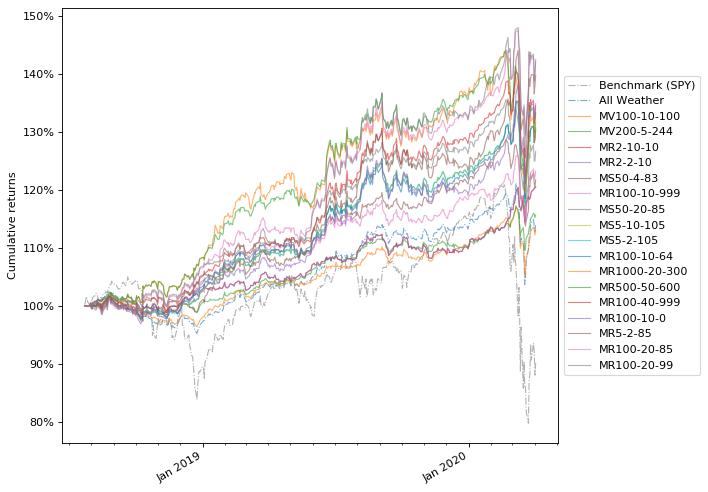

In [38]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plot_rolling_returns_from_perf_array(all, bm_returns, extra_bm=1)
print_table_from_perf_array(all, bm_returns, True)

We can see that SAW-GA (All-Weather with Sentiments as trading signals, optimised via GA) has resulted in better performance

For All-Weather, we can see that annual, cumulative returns, sharpe ratio are better than the baseline SPY.
But with SAW-GA (Max Returns), we can see that these metrics are even better!

And for risk-adverse individuals, looking to minimise volatility, we can see that SAW-GA (Min Volatility) achieves lower annual volatility, and better max drawdown as compared to All-Weather and the benchmark, while maintaining decent annual returns that still beat the benchmark!

---
---

👷‍♂️ WIP 👷‍♂️

### Use Modern Portfolio Theory, but use trading signals to adjust upper and lower bounds of 'risk'.

Let's call this "Sentimental MPT" (SMPT)

Baseline: Modern Portfolio Theory

In [78]:
tz = pytz.timezone('US/Mountain')
t_end = tz.localize(datetime.strptime('2020-06-06', '%Y-%m-%d'))  # pd.Timestamp.utcnow()
t_start = t_end - 2500 * pd.tseries.offsets.BDay()

stocks = ['VTI', 'TLT', 'IEF', 'GLD', 'DBC']  # list of stocks used by All-Weather

yahoo_financials = YahooFinancials(stocks)


In [79]:
t_end = datetime.now(tz)
t_start = t_end - 1 * pd.tseries.offsets.BDay()

print(t_end.strftime('%Y-%m-%d'))

aw_data = yahoo_financials.get_historical_price_data(
    t_start.strftime('%Y-%m-%d'), 
    t_end.strftime('%Y-%m-%d'), 
    'daily'
)

print((aw_data['VTI']['prices']))

2020-05-09
[{'date': 1588944600, 'high': 147.6300048828125, 'low': 145.8800048828125, 'open': 146.4499969482422, 'close': 147.47000122070312, 'volume': 4248400, 'adjclose': 147.47000122070312, 'formatted_date': '2020-05-08'}, {'date': 1588968000, 'high': 147.6300048828125, 'low': 145.8800048828125, 'open': 146.4499969482422, 'close': 147.47000122070312, 'volume': 3647531, 'adjclose': 147.47000122070312, 'formatted_date': '2020-05-08'}]


In [80]:
print(type(t_end), type(datetime.now(tz)))

<class 'datetime.datetime'> <class 'datetime.datetime'>


In [81]:
# illustrate theory
tz = pytz.timezone('US/Mountain')
t_end = tz.localize(datetime.strptime('2020-01-01', '%Y-%m-%d'))  # pd.Timestamp.utcnow()
t_start = t_end - 2500 * pd.tseries.offsets.BDay()

stocks = ['VTI', 'TLT', 'IEF', 'GLD', 'DBC']  # list of stocks used by All-Weather

yahoo_financials = YahooFinancials(stocks)
aw_data = yahoo_financials.get_historical_price_data(
    t_start.strftime('%Y-%m-%d'), 
    t_end.strftime('%Y-%m-%d'), 
    'daily'
)

SIZE = 100
df_data_all = {}
df_data = {} # only last n

for i in range(len(stocks)):
    df_data_all[i] = pd.DataFrame(aw_data[stocks[i]]['prices']).filter(['formatted_date', 'adjclose'])    
    df_data[i] = pd.DataFrame(aw_data[stocks[i]]['prices'])[-(SIZE+1):].filter(['formatted_date', 'adjclose'])
    
prices = pd.DataFrame(np.column_stack(tuple(df_data[i]['adjclose'] for i in range(len(stocks)))), columns=stocks)

0.06664431961536903


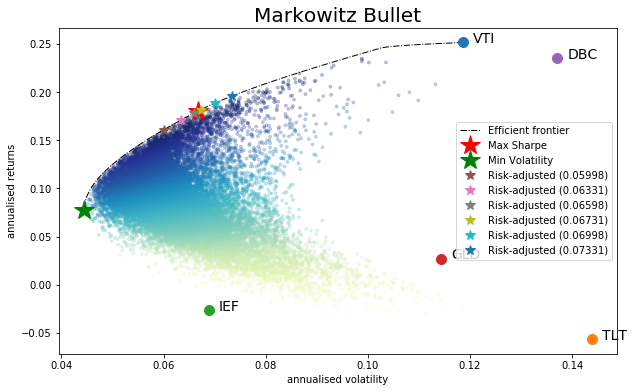

In [82]:
from pypfopt.base_optimizer import portfolio_performance
from utils import generate_markowitz_bullet, get_mu_sigma, optimal_portfolio

# Get mu and S from prices
mu, S = get_mu_sigma(prices)

# w_max_sharpe, _, _ = optimal_portfolio(mu, S, "max_sharpe", get_entire_frontier=False)
w_max_sharpe, opt_ret, opt_risk = optimal_portfolio(mu, S, "max_sharpe", get_entire_frontier=True)
r_ms, v_ms, _ = portfolio_performance(mu, S, w_max_sharpe)
print(v_ms)

# adjust expected volatility - If bullish, we will take more risk/volatility, if bearish, we will take less risk/volatility
vol = [-0.1, -0.05, -0.01, 0.01, 0.05, 0.10]
vol = [v_ms*(1+v) for v in vol]

fig, ax = plt.subplots(figsize=(10, 6))
_ = generate_markowitz_bullet(prices, ax=ax, verbose=False)

for v in vol:
#     print(v)
    weights, _, _ = optimal_portfolio(mu, S, "efficient_risk", get_entire_frontier=False, **{"target_volatility": v})
    r, v, _ = portfolio_performance(mu, S, weights)
    ax.plot(v, r, '*', markersize=10, label=f"Risk-adjusted ({v:.4})")
ax.legend()


In [83]:
%matplotlib notebook

stocks = ['VTI', 'TLT', 'IEF', 'GLD', 'DBC']  # list of stocks used by All-Weather
NPOP = 200
NGEN = 5
seed = 1055
opt_type = "smpt"
objective = "min_vol"  # max_sharpe, max_ret, min_vol
toSolve = False

# ---------------------------------------------------
# SMPT_GA_MAX_RET
pickle_name = f"./output/{opt_type.upper()}_GA_{objective.upper()}"

kpi_map = {
    "max_ret": "algorithm_period_return",
    "max_sharpe": "sharpe",
    "min_vol": "algo_volatility"
}

kwargs = {"social_media": social_media, "bundle_name": bundle_name, 
          "train_start": train_start, "train_end": train_end, "capital_base": capital_base, 
          "trade_freq": trade_freq, "kpi": kpi_map.get(objective, "sharpe")}

if toSolve:
    top10, log, hof = ga.run_smpt_ga("FitnessMax", NPOP, NGEN, pickle_name, 
                                    eval_fn=ga.eval_final_perf, stocks=stocks, seed=seed, **kwargs)
else:
    with open(f"{pickle_name}.pickle", "rb+") as f:
        top10 = pickle.load(f)    

        
best = top10[0]
w_smpt = best

MPT (Max Sharpe)
GA-optimised SMPT for min_vol


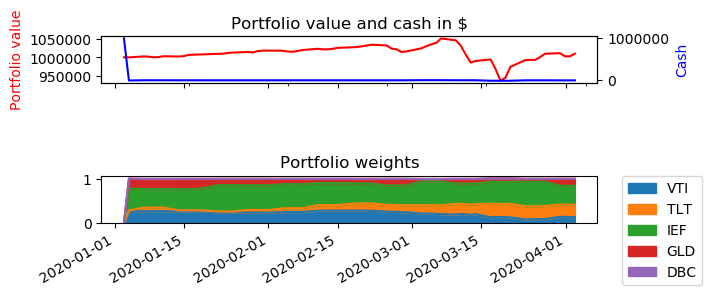

,Baseline,MPT (Max Sharpe),SMPT-GA (min_vol)
Annual return,-65.358%,13.6%,4.014%
Cumulative returns,-23.603%,3.292%,1.005%
Annual volatility,55.046%,18.01%,14.517%
Sharpe ratio,-1.64796,0.797535,0.342965
Calmar ratio,-1.91638,1.07111,0.364714
Stability,0.684932,0.00715911,0.0250253
Max drawdown,-34.105%,-12.697%,-11.006%
Omega ratio,0.725629,1.18494,1.07834
Sortino ratio,-2.13837,1.03741,0.440931
Skew,-0.190885,-1.07192,-0.888137


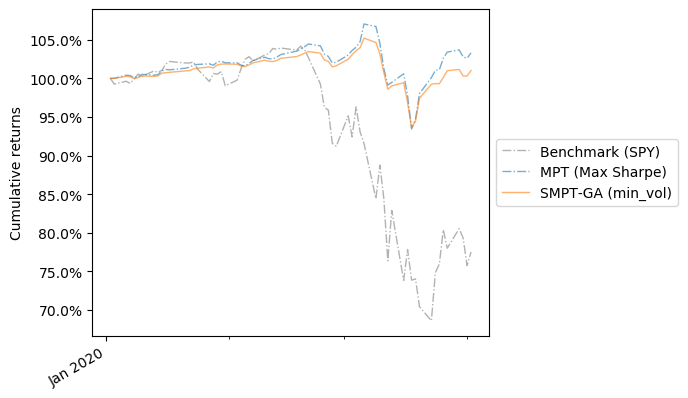

In [84]:
%matplotlib inline

# Test on out-of-sample data
plt.style.use('default')
print(f"MPT (Max Sharpe)")



algo_smpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                         collect_before_trading=False, history=args['history'],
                        rebalance_freq=trade_freq, mpt_adjustment=ga.smpt_ga_trading_fn,
                        **{"weights": w_smpt, "social_media": social_media})
print(f"GA-optimised SMPT for {objective}")
smpt_ga_test = run(f"SMPT-GA ({objective})", algo_smpt, bundle_name, test_start, test_end, capital_base, analyze=True)

plot_rolling_returns_from_perf_array([bm_mpt_test, smpt_ga_test], bm_test, extra_bm=1)
print_table_from_perf_array([bm_mpt_test, smpt_ga_test], bm_test, True)

GA-optimised SMPT for min_vol


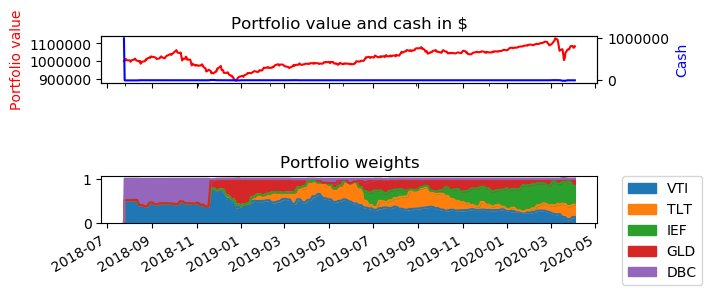

,Baseline,MPT (Max Sharpe),SMPT-GA (min_vol)
Annual return,-6.776%,4.266%,4.848%
Cumulative returns,-11.259%,7.352%,8.372%
Annual volatility,25.207%,12.485%,9.824%
Sharpe ratio,-0.151275,0.397112,0.531081
Calmar ratio,-0.198688,0.210562,0.29552
Stability,0.228746,0.277838,0.501369
Max drawdown,-34.105%,-20.259%,-16.404%
Omega ratio,0.966166,1.07944,1.10265
Sortino ratio,-0.199684,0.528369,0.697343
Skew,-0.764533,-0.663126,-0.942821


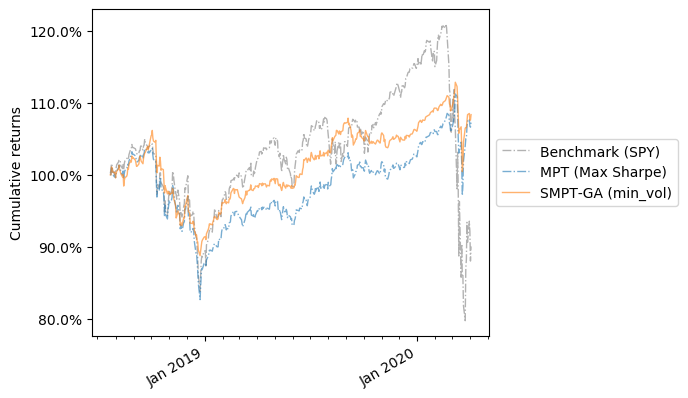

In [85]:
# Test on entire period
algo_smpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                         collect_before_trading=False, history=args['history'],
                        rebalance_freq=trade_freq, mpt_adjustment=ga.smpt_ga_trading_fn,
                        **{"weights": w_smpt, "social_media": social_media})
print(f"GA-optimised SMPT for {objective}")
smpt_ga_all = run(f"SMPT-GA ({objective})", algo_smpt, bundle_name, train_start, test_end, capital_base, analyze=True)

plot_rolling_returns_from_perf_array([bm_mpt, smpt_ga_all], bm_returns, extra_bm=1)
print_table_from_perf_array([bm_mpt, smpt_ga_all], bm_returns, True)

In [86]:
from ga import compareResults

opt_type = "smpt"
# objective = "max_ret"  # max_sharpe, max_ret, min_vol
# base_name = f"{opt_type.upper()}_GA_{objective.upper()}"

kwargs = {"social_media": social_media, "bundle_name": bundle_name, 
          "train_start": train_start, "train_end": train_end, 
          "test_start": test_start, "test_end": test_end, 
          "capital_base": capital_base, 
          "stocks": stocks, "trade_freq": trade_freq
         }

test_smpt_mr, all_smpt_mr = compareResults(base_name=f"./output/{opt_type.upper()}_GA_MAX_RET", opt_type=opt_type, prefix="MR", **kwargs)
test_smpt_mv, all_smpt_mv = compareResults(base_name=f"./output/{opt_type.upper()}_GA_MIN_VOL", opt_type=opt_type, prefix="MV", **kwargs)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.38s/it]


In [89]:
test_smpt = test_smpt_mr + test_smpt_mv
all_smpt = all_smpt_mr + all_smpt_mv

Test on out-of-sample data


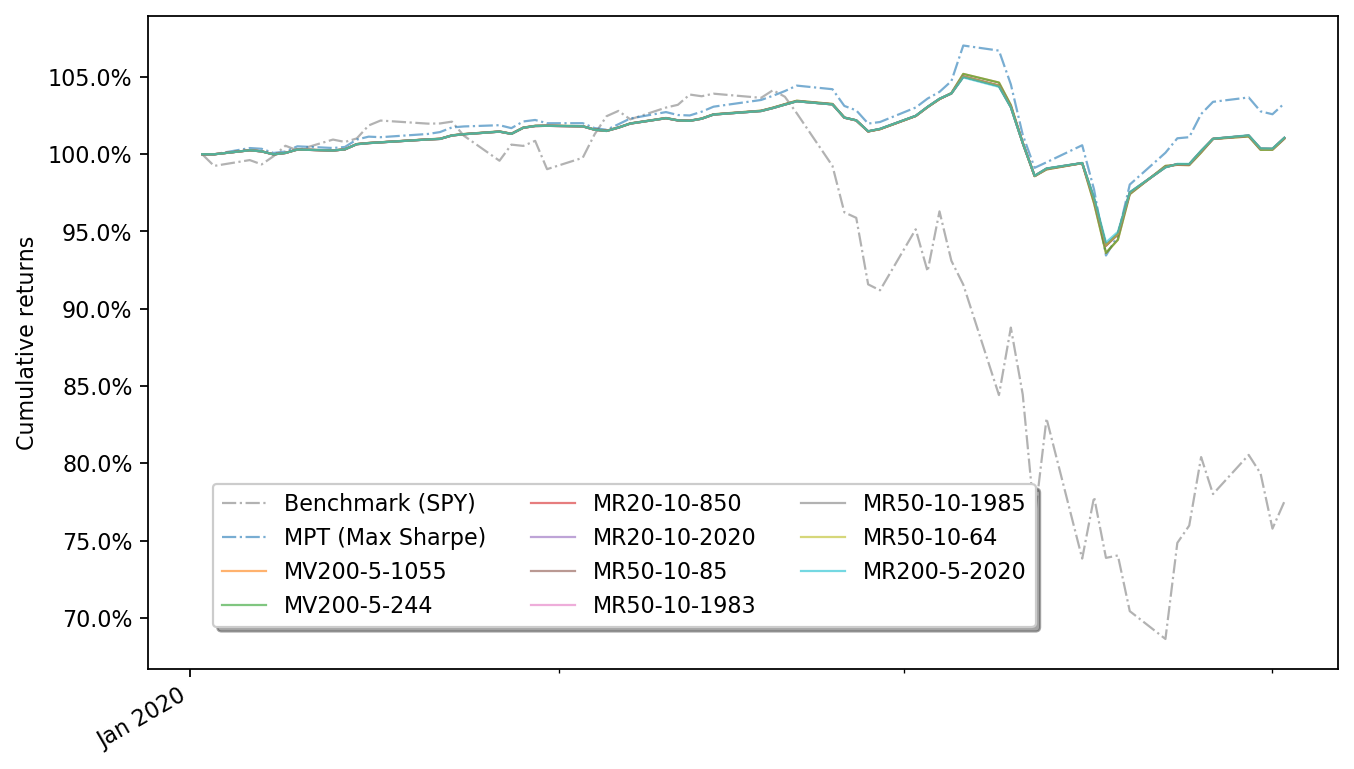

In [91]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=160, facecolor='w', edgecolor='k')

# sort by performance (cumulative returns)
all_smpt.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=False)
test_smpt.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=False)

all = [bm_mpt] + all_smpt
test = [bm_mpt_test] + test_smpt

print('Test on out-of-sample data')
ax = plot_rolling_returns_from_perf_array(test, bm_test, extra_bm=1)
_ = print_table_from_perf_array(test, bm_test, True)

ax.legend(loc='upper center', bbox_to_anchor=(0.4, 0.3), shadow=True, ncol=3)

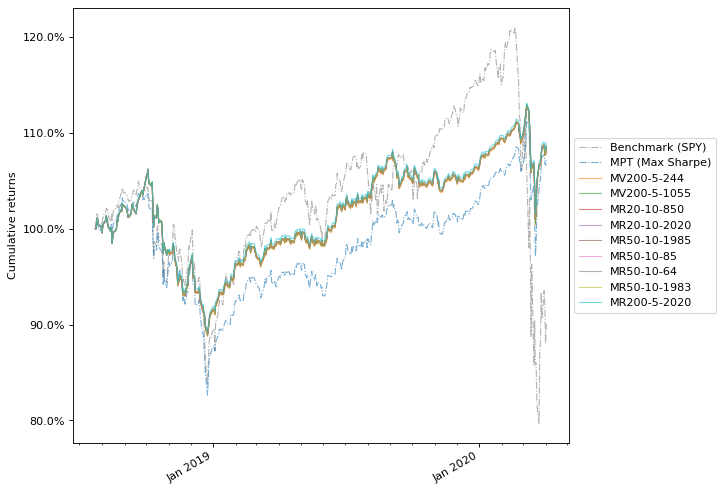

In [51]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plot_rolling_returns_from_perf_array(all, bm_returns, extra_bm=1)
print_table_from_perf_array(all, bm_returns, True)

It appears that SMPT-GA (MPT with Sentiments as trading signals, optimised via GA) tended to converge to certain parameters and performance, which was only slightly better than MPT (Max Sharpe) for the entire period, and in fact, fared worse for the out-of-sample period!

# Testing area